In [22]:
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_csv('2024-2015MainResidencyMatchData.csv')
data.head()
data = data[data != '#DIV/0!'].dropna()

### The Residency Match and Scramble
The main residency match is a process where medical school graduates apply for positions in residency programs, which are required for specialization in medicine. Applicants rank their preferred programs, and residency programs rank the applicants they wish to offer positions to. The match is then conducted using an algorithm by the National Resident Matching Program (NRMP), which pairs applicants with programs based on these rankings. However, not all applicants are matched to a position due to the high competition. If this occurs, they enter the SOAP (Supplemental Offer and Acceptance Program), a "scramble" period, where unmatched applicants can apply for unfilled positions through an intense and expedited process. Applicants only learn which specialty programs have unfilled positions after the matching algorithm results are released, which takes months. To address the uncertainty of what options are available during the "scramble," we will use supervised machine learning to predict how many unfilled positions each specialty will have, based on features known prior to the matching algorithm. As a result, applicants will be able to know before the Match Day about the likely number of positions under each specialty type that would be available to them in the “scramble” process, in the case that they are unmatched. 



### Feature Engineering
The original data included features such as 'No of Total Matches', and '% Filled by Seniors'. However, we want to use the model as an indicator of the number of unfilled positions in each specialty prior without having to rely on the NRMP Matching algorithm, so any data related to post-match metrics got dropped. This left even fewer features remaining, so feature engineering was used to create the following features from existing data:

4. Applicants per Position Ratio =  No of Total Applicants to Specialty / No of Offered Positions for Specialty
5. No Programs for Specialty to All Programs Ratio = No of Programs for Specialty/ Total PGY-1 No of Programs for Given Year
6. US MD Senior Applicants to Total Applicants Ratio = No of Senior Applicants to Specialty / No of Total Applicants to Specialty
7. Avg Program Size (in number of positions) = No of Offered Positions for Specialty / No of Programs for Specialty
8. No of Applications to the Specialty to All Applications Ratio = No of Total Applicants to Specialty/ Total PGY-1 No of Total Applicants for Given Year



The following table outlines the features used to predict or explain the target variable **"Unfilled Positions"**

| **Feature**                                       | **How it was Calculated**                                            | **Intuition/Significance**                                               |
|--------------------------------------------------|---------------------------------------------------------------------|-------------------------------------------------------------------------|
| **1. Specialty**                                  | Specialty                                                           | This feature represents the specific medical specialty under consideration. It's a categorical variable that helps identify which specialty is being analyzed. |
| **2. Unfilled Positions**                         | Target variable to predict                                          | The number of positions that remain unfilled in the given specialty. This is the main target of prediction in the machine learning model. |
| **3. No of Offered Positions**                   | Number of Offered Positions for the Specialty                        | This feature measures the supply of positions available for a given specialty. It gives an idea of how many positions are being offered for that specialty in a given year. |
| **4. No of Total Applicants**                    | Number of Total Applicants to the Specialty                          | This feature indicates the demand for positions in a specialty, representing how many applicants are interested in that specialty. |
| **5. Applicants per Position Ratio**              | Number of Total Applicants to Specialty / Number of Offered Positions for Specialty | This ratio shows the competitiveness of positions in the specialty. A higher ratio indicates more applicants per available position, suggesting higher competition. |
| **6. No Programs for Specialty to All Programs Ratio** | Number of Programs for Specialty / Total PGY-1 Number of Programs for the Given Year | This ratio shows the "commonness" of a specialty. A higher ratio means the specialty is more common (more programs available), while a lower ratio suggests it is rarer. |
| **7. US MD Senior Applicants to Total Applicants Ratio** | Number of Senior Applicants to Specialty / Number of Total Applicants to Specialty | This feature indicates the desirability of the specialty. A higher ratio means more senior US MD applicants are applying, which indicates a more sought-after specialty (US MD applicants are generally preferred by residency programs to other types of applicants so have a competitive advantage). |
| **8. Avg Program Size (in number of positions)** | Number of Offered Positions for Specialty / Number of Programs for Specialty | This feature reflects the average size of programs within the specialty. Larger average program sizes may indicate greater opportunities for applicants to match. |
| **9. No of Applications to the Specialty to All Applications Ratio** | Number of Total Applicants to Specialty / Total PGY-1 Number of Total Applicants for the Given Year | This ratio measures the popularity of a specialty. A higher ratio indicates that the specialty is more popular compared to others because it received relatively more applications. |
| **10. Year**                                       | Year                                                                | This is simply the year of the data. It may help capture trends or changes in patterns related to unfilled positions over the time frame of 2015 to 2024. |




Data Exploration

In [23]:
print(data.shape)
data= data[~data['Specialty'].str.contains('Total PGY-1')] # is not a real specialty, just a total row for the year
print(data.shape)
print('Number of Specialties',len(data['Specialty'].unique()))
data = pd.get_dummies(data, columns=['Specialty', 'Year'])

data.describe()

(495, 10)
(485, 10)
Number of Specialties 54


,Unfilled Positions,No of Offered Positions,No of Total Applicants,No Programs for Specialty to All Programs Ratio,US MD Senior Applicants to Total Applicants Ratio,Avg Program Size,No of Applications to Specialty to All Applications Ratio
count,485.000000,485.000000,485.000000,485.000000,485.000000,485.000000,485.000000
mean,35.226804,676.461856,1227.435052,0.020618,0.584396,3.634206,0.020619
std,106.323973,1439.934106,2289.770117,0.029701,0.202354,3.118041,0.038282
min,0.000000,1.000000,2.000000,0.000179,0.000000,0.333333,0.000038
25%,0.000000,8.000000,38.000000,0.000997,0.470588,1.500000,0.000647
50%,1.000000,49.000000,211.000000,0.005745,0.609566,2.298701,0.003591
75%,7.000000,717.000000,1550.000000,0.029910,0.728814,4.987654,0.024075
max,636.000000,10261.000000,15451.000000,0.142244,1.000000,15.819820,0.231240


In [24]:
print(data.shape) # 10 original columns, -1 Specialty, + 54 dummy Specialties, -1 Year, + 10 dummy Years = 72 columns now
data_without_specialty_or_year=data.drop(columns=[col for col in data.columns if 'Specialty' in col or 'Year' in col], inplace=False)
data_without_specialty_or_year.corr()
#The correlation is not close enough to +/-1 between any two variables that they would be obviously redundant, except for No of Total Applicants and No of Offered Positions


(485, 72)


,Unfilled Positions,No of Offered Positions,No of Total Applicants,Applicants per Position Ratio,US MD Senior Applicants to Total Applicants Ratio,Avg Program Size
Unfilled Positions,1.000000,0.611499,0.601689,-0.216713,-0.241848,0.423646
No of Offered Positions,0.611499,1.000000,0.967184,-0.314869,-0.298540,0.816368
No of Total Applicants,0.601689,0.967184,1.000000,-0.282076,-0.300801,0.812177
Applicants per Position Ratio,-0.216713,-0.314869,-0.282076,1.000000,-0.098970,-0.336610
US MD Senior Applicants to Total Applicants Ratio,-0.241848,-0.298540,-0.300801,-0.098970,1.000000,-0.263691
Avg Program Size,0.423646,0.816368,0.812177,-0.336610,-0.263691,1.000000


['Specialty_Anesthesiology', 'Specialty_Child Neurology', 'Specialty_Dermatology', 'Specialty_Emergency Med-Anesthesiology', 'Specialty_Emergency Med-Family Med', 'Specialty_Emergency Medicine', 'Specialty_Family Med-Preventive Med', 'Specialty_Family Medicine', 'Specialty_Family Medicine-ONMM', 'Specialty_Internal Medicine (Categorical)', 'Specialty_Interventional Radiology (Integrated)', 'Specialty_Medicine-Anesthesiology', 'Specialty_Medicine-Dermatology', 'Specialty_Medicine-Emergency Med', 'Specialty_Medicine-Family Medicine', 'Specialty_Medicine-Medical Genetics', 'Specialty_Medicine-Neurology', 'Specialty_Medicine-Pediatrics', 'Specialty_Medicine-Preliminary (PGY-1 Only)', 'Specialty_Medicine-Preventive Med', 'Specialty_Medicine-Primary', 'Specialty_Medicine-Psychiatry', 'Specialty_Neurodevelopmental Disabilities', 'Specialty_Neurological Surgery', 'Specialty_Neurology', 'Specialty_OB/GYN-Preliminary (PGY-1 Only)', 'Specialty_Obstetrics-Gynecology', 'Specialty_Orthopedic Surgery

C:\Users\sarah\AppData\Local\Temp\ipykernel_66176\4274428301.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([x.split('_')[1] for x in specialties_lt_10], rotation=90, fontsize=12)
C:\Users\sarah\AppData\Local\Temp\ipykernel_66176\4274428301.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels([x.split('_')[1] for x in specialties_gt_10], rotation=90, fontsize=12)


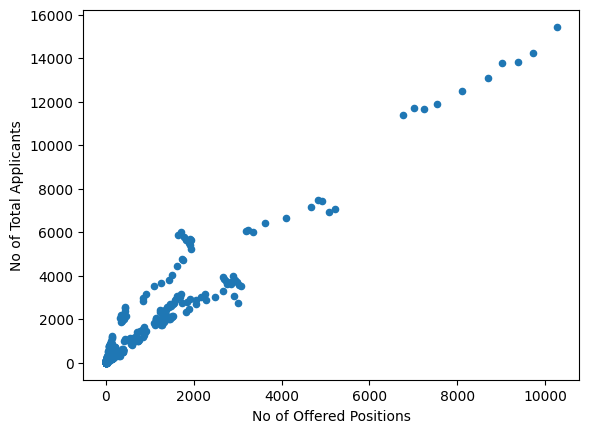

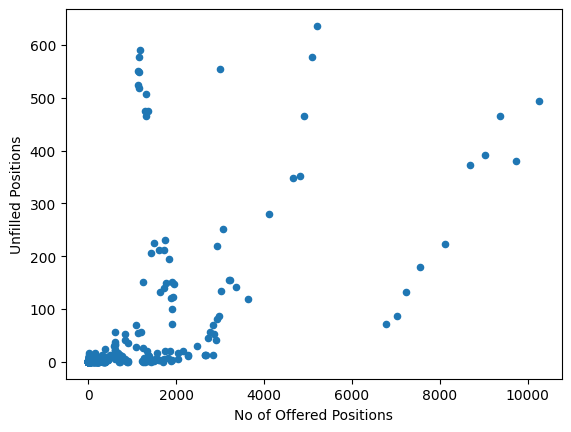

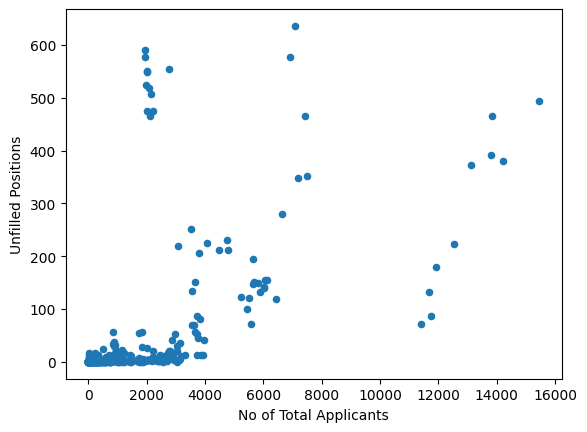

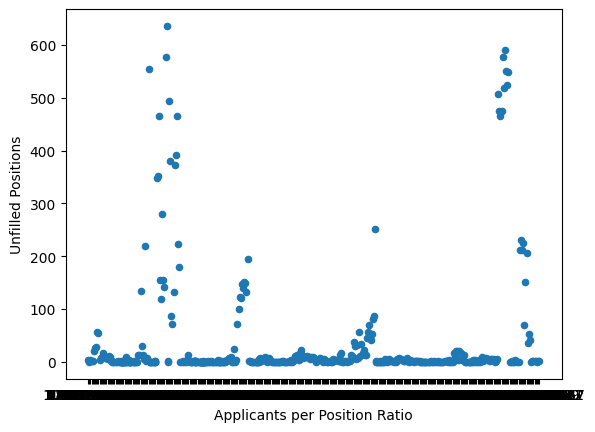

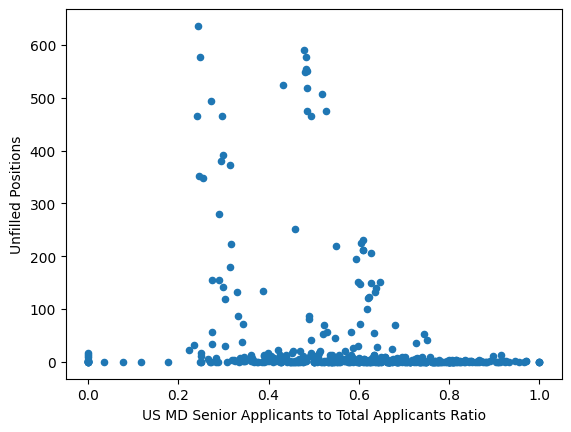

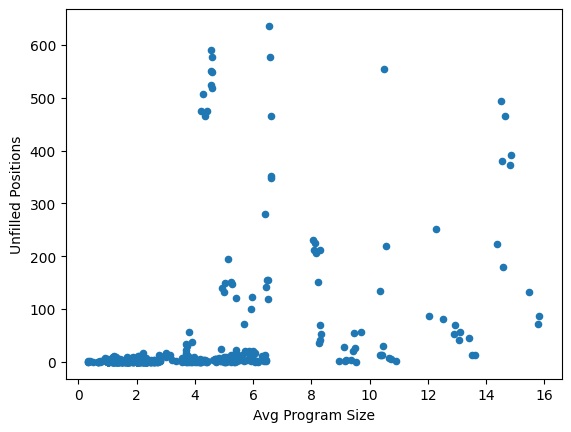

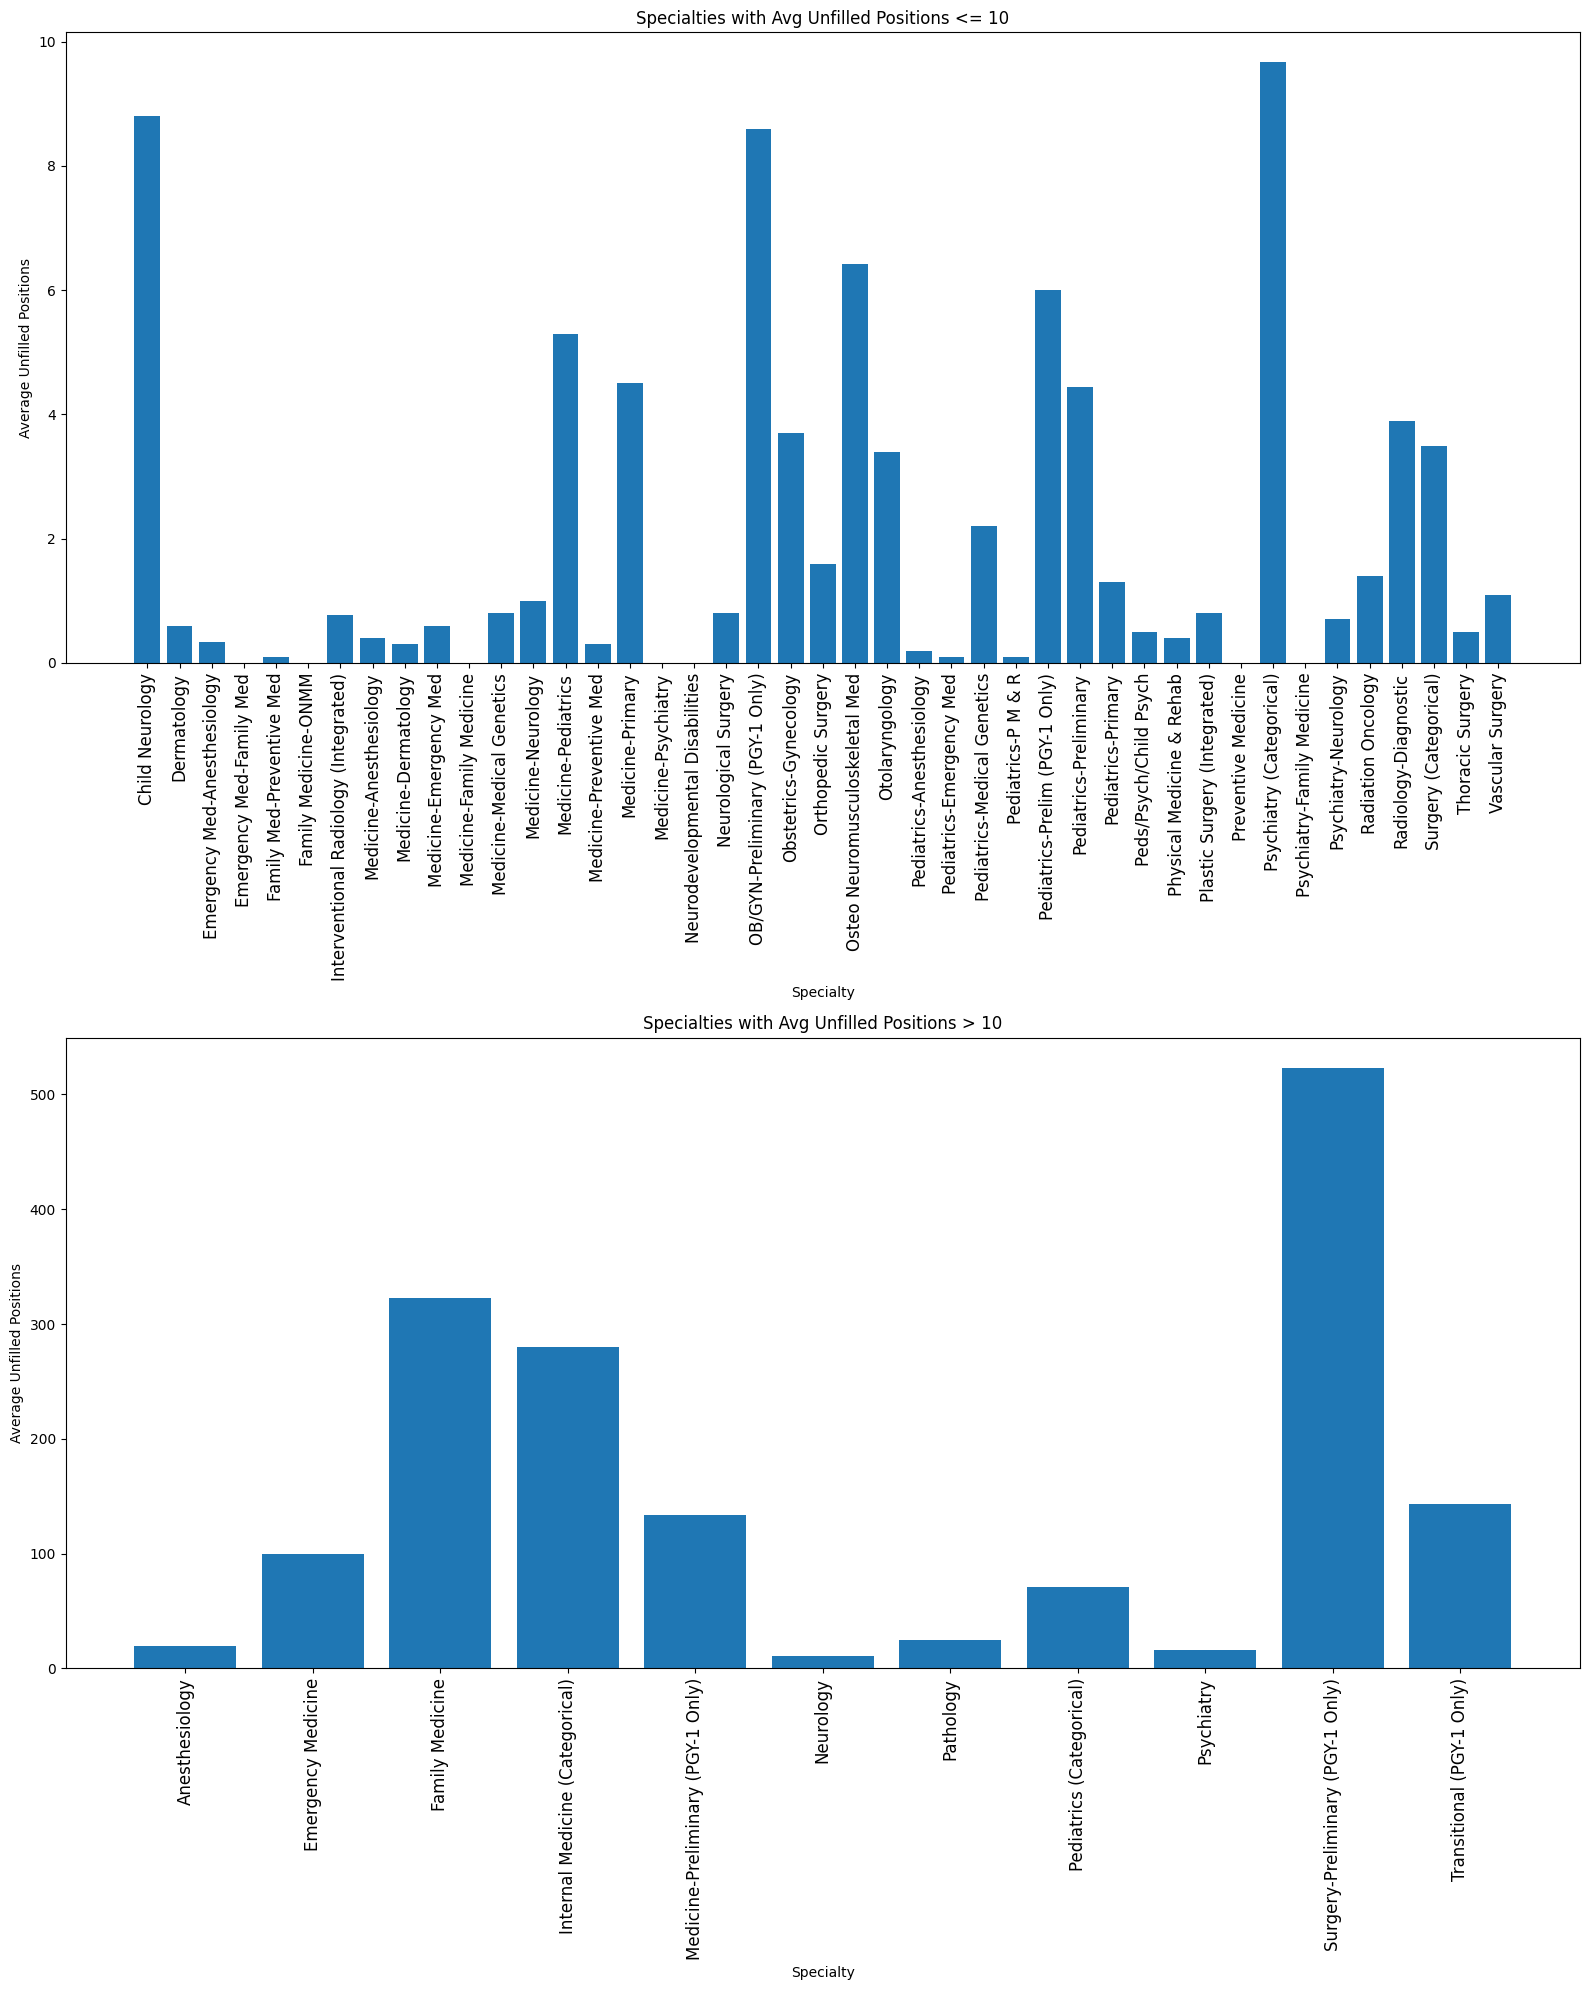

In [25]:
data_without_specialty_or_year.plot.scatter(x='No of Offered Positions', y='No of Total Applicants')
#But both should be kept because there is still some variation between them

data_without_specialty_or_year.plot.scatter(x='No of Offered Positions', y='Unfilled Positions')
#Suggests that few applicants means few unfilled positions, perhaps an indicator of selectivity

data_without_specialty_or_year.plot.scatter(x='No of Total Applicants', y='Unfilled Positions')
#Suggests that few applicants means few unfilled positions, perhaps an indicator of selectivity

data_without_specialty_or_year.plot.scatter(x='Applicants per Position Ratio', y='Unfilled Positions')
#There is not a clear relationship between the two features, but it shows there is some consistency in the number of Applicants per Position, regardless of the outcome of unfilled positinos

data_without_specialty_or_year.plot.scatter(x='US MD Senior Applicants to Total Applicants Ratio', y='Unfilled Positions')
#As expected, when the US MD Senior Applicants Ratio is higher, there is often fewer unfilled positions

data_without_specialty_or_year.plot.scatter(x='Avg Program Size', y='Unfilled Positions')
#As expected, when the program size is small it seems there are usually little to no unfilled positions

#bar graph for specialties:
specialty_columns = [col for col in data.columns if 'Specialty_' in col]
print(specialty_columns)
avg_unfilled_positions_per_specialty=[] #the average over the years
for specialty in specialty_columns:
    avg_unfilled_positions_per_specialty.append(data[data[specialty]==True]['Unfilled Positions'].mean())

less_than_10 = [(specialty, avg) for specialty, avg in zip(specialty_columns, avg_unfilled_positions_per_specialty) if avg <= 10]
greater_than_10 = [(specialty, avg) for specialty, avg in zip(specialty_columns, avg_unfilled_positions_per_specialty) if avg > 10]

specialties_lt_10, values_lt_10 = zip(*less_than_10) if less_than_10 else ([], [])
specialties_gt_10, values_gt_10 = zip(*greater_than_10) if greater_than_10 else ([], [])

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(16, 20))

# Plot for values <= 100
ax1.bar(specialties_lt_10, values_lt_10)
ax1.set_title('Specialties with Avg Unfilled Positions <= 10')
ax1.set_xlabel('Specialty')
ax1.set_ylabel('Average Unfilled Positions')
ax1.set_xticklabels([x.split('_')[1] for x in specialties_lt_10], rotation=90, fontsize=12)

# Plot for values > 100
ax2.bar(specialties_gt_10, values_gt_10)
ax2.set_title('Specialties with Avg Unfilled Positions > 10')
ax2.set_xlabel('Specialty')
ax2.set_ylabel('Average Unfilled Positions')
ax2.set_xticklabels([x.split('_')[1] for x in specialties_gt_10], rotation=90, fontsize=12)

plt.tight_layout()


931.7818943298969


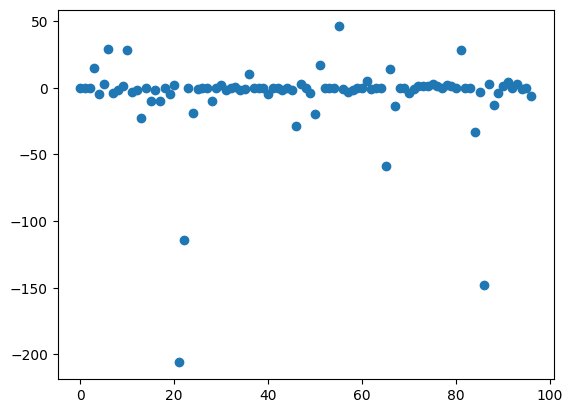

<Figure size 640x480 with 0 Axes>

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

%matplotlib inline


data_encoded = data
X = data_encoded.drop(['Unfilled Positions'], axis=1)
y = data_encoded['Unfilled Positions']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
tree = DecisionTreeRegressor()

grid = GridSearchCV(estimator=tree, param_grid={'max_depth': range(1, 21)}, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

best_tree = DecisionTreeRegressor(max_depth=grid.best_params_['max_depth'])
best_tree.fit(X_train, y_train)
y_pred = best_tree.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(mse)

residuals = y_pred - y_test 
plt.scatter(range(len(y_test)), residuals)
plt.show()
plt.savefig("image_0.png")